# Robinson Crusoe

With ``respy`` you are able to prototype a model similar to [Keane and Wolpin (1997)]( https://www.jstor.org/stable/10.1086/262080) in minutes. We will showcase the implementation of a the Robinson Crusoe economy as a discrete choice dynamic programming model. Throughout the notebook you find indented text which tell parts of Robinson's story and motivates the model. We will first set the scene with a broad introduction and then turn to the actual model specification. We continue by simulating the model and analyze its comparative statics. We then extend the model and showcase the estimation of the model parameters.  


Just to be clear, don't missinterpret the fact that we explain ``respy`` using such a simplistic model. ``respy`` is not a toy and can just as well solve state-of-the-art structural models. It's just easier to explain respy in a situation where we don't have to explain a complicated model at the same time. 

In [5]:
%matplotlib inline

import io
import matplotlib.pyplot as plt
import pandas as pd
import respy as rp
import yaml
import seaborn as sns
import numpy as np

from pathlib import Path
from time import time

plt.style.use("../_static/respy.mplstyle")

## Introduction

> After setting sail against his parents wishes, being captured by pirates, escaping from them, building a plantation, and setting sail again to capture slaves in Africa, [Robinson Crusoe](https://en.wikipedia.org/wiki/Robinson_Crusoe) stranded on a small island. He is alone with one dog, two cats, and only some supplies. He goes fishing to make ends meet and if he is too tired he will relax in his hammock.

In the discrete choice dynamic programming model, Robinson chooses every period to either go fishing, $a = 0$, or spend the day in the hammock, $a = 1$, to maximize his expected sum of discounted lifetime utiltiy. The utility of a choice, $U(s_t, a_t)$, depends on the state $s_t$, which contains information on the individual's characteristics, and the chosen alternative $a_t$. For working alternatives like fishing utility consists of two components, a wage and a non-pecuniary component.

$$
    U(s_t, a_t) = W(s_t, a_t) + N(s_t, a_t)
$$

For non-working alternatives like the hammock, $W(s_t, a_t) = 0$. The wage is defined as

$$\begin{align}
        W(s_t, a_t)  &= r_a \exp\{x^w_{at} \beta^w_a + \epsilon_{at}\}\\
    \ln(W(s_t, a_t)) &= \ln(r_a) + x^w_{at} \beta^w_a + \epsilon_{at}
\end{align}$$


where $r_a$ is normally a market rental price for the skill units generated in the exponential expression. Another interpretation is that $ln(r_a)$ is simply the constant in the skill units. The skill units are generated by two components. $x^w_{at}$ and $\beta^w_a$ are the choice- and time-dependent covariates and parameters related to the wage signaled by superscript $w$. The last term, $\epsilon_{at}$ is a random shock.

The non-pecuniary rewards for working alternatives are simply a vector dot product of covariates $x_t^w$ and parameters $\beta^w$. The superscript $w$ signals that the components belong to working alternatives.

$$
    N^w(s_t, a_t) = x_t^w\beta^w
$$

The non-pecuniary reward for non-working alternatives is very similar except that the shocks enter the equation additively. Superscript $n$ stands for non-pecuniary.

$$
    N^n(s_t, a_t) = x_t^n\beta^n + \epsilon_{at}
$$

## Model specification

How can we express the equations and parameters with ``respy``? The following cell contains the code to write a ``.csv`` file which is the cornerstone of a model as it contains all parameters and some other specification. It is quickly written and easily loaded with ``pandas``.

In [6]:
%%writefile robinson-crusoe.csv

category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_fishing,constant,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
lagged_choice_1_hammock,constant,1

Overwriting robinson-crusoe.csv


In [7]:
params = pd.read_csv("robinson-crusoe.csv", index_col=["category", "name"])
params

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

The parameters :class:`pd.DataFrame` contains a two-level :class:`pd.MultiIndex` to group parameters in categories. ``name`` should be uniquely assigned in each category or otherwise only the sum of identically named parameters is identified. ``value`` contains the value of the parameter. Note that we named Robinson's alternatives ``"fishing"`` and ``"hammock"`` and we have to use the names consistently. As long as you stick to lowercase letters separated by underscores, you can choose any name you want.

The parameter specification contains following entries:

- The first entry contains the discount factor of individuals.
- The second category ``"wage_fishing"`` contains the parameters of the log wage equation for fishing. The group contains only one name called ``"exp_fishing"`` where ``"exp_*"`` is an identifier in the model for experience accumulated in a certain alternative. ``respy`` requires that you respect those identifiers of which there are not many and reference your alternatives consistently with the same name. If you stick to lowercase letters possibly separated by underscores, you are fine.
- The third category concerns the non-pecuniary reward of fishing.

In [14]:
%%writefile robinson-crusoe.yaml

estimation_draws: 200
estimation_seed: 500
estimation_tau: 50
interpolation_points: -1
n_periods: 10
simulation_agents: 1_000
simulation_seed: 132
solution_draws: 500
solution_seed: 456
covariates:
    constant: "1"
    not_fishing_last_period: "lagged_choice_1 != 'fishing'"

Overwriting robinson-crusoe.yaml


In [15]:
params = pd.read_csv("robinson-crusoe.csv", index_col=["category", "name"])
options = yaml.safe_load(Path("robinson-crusoe.yaml").read_text())

In [16]:
params

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

In [17]:
options

{'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 50,
 'interpolation_points': -1,
 'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}}

## Simulating a Model

We are now ready to simulate the model.

In [18]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

We can inspect Robinson's decisions period by period.

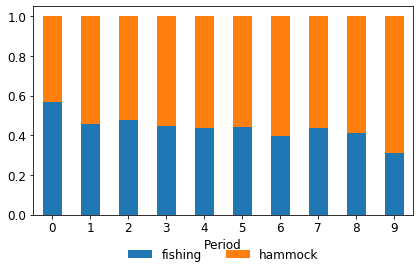

In [21]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax
)


plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=2)

plt.show()
plt.close()


We can also analyze the persistence in decisions.

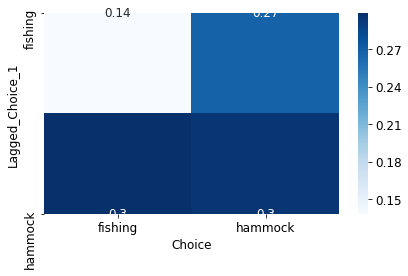

In [23]:
data = pd.crosstab(df.Lagged_Choice_1, df.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True)

## Comparative statics

We now study how Robinson's behavior changes as we inrease the returns to experience. We do so by plotting the average level of final exerience in the sample under the different parameterizations.

This analysis of the comparative statics of the model is straightforward to implement. In models of educational choice, this type of analysis is often applied to evaluate the effect of alternative tuition policies on average educational attainment. See Keane & Wolpin (1997,2001) for example. The basic structure of the analysis remains the same.

In [24]:
# Specification of grid for evaluation
num_points = 15    
grid_start = 0.0
grid_stop = 0.3

grid_points = np.linspace(grid_start, grid_stop, num_points)

rslts = list()
for value in grid_points:
    
    params.loc["wage_fishing", "exp_fishing"] = value

    df = simulate(params)

    stat = df.groupby("Identifier")["Experience_Fishing"].max().mean()
    rslts.append(stat)

We collected all results in `rslts` and are ready to create a basic visualization.

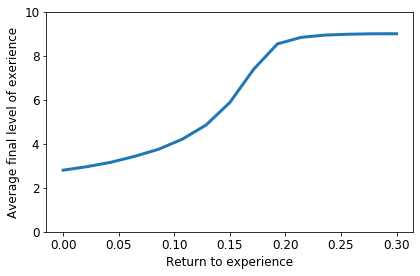

In [25]:
fig, ax = plt.subplots()

ax.plot(grid_points, rslts)

ax.set_ylim([0, 10])
ax.set_xlabel("Return to experience")
ax.set_ylabel("Average final level of exerience")

plt.show()
plt.close()

In the absence of any returns to experience, Robinson still spends more than two periods fishing. This share then increases with the reuturn. Starting at around 0.2, Robinson spends all his time fishing.

## A small extension

> At some point Crusoe notices that a group of cannibals occasionally visits the island and celebrate one of their dark rituals. But then, a prisoner can escape and becomes Crusoe's new friend Friday whom he teaches English. In return Friday can share his knowledge once to help Robinson improve his fishing skills, but that is only possible after Robinson tried at least once to go fishing.

- show that there are two possible ways to implement Friday, experience and lagged_choice
- show that there are two possible ways to restrict talking to Friday to a one-time choice

In [57]:
%%writefile robinson-crusoe.csv

category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
wage_fishing,contemplation_with_friday,0.4
nonpec_fishing,constant,-1
nonpec_friday,constant,-1
nonpec_friday,not_fishing_last_period,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_friday,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_friday_fishing,0
shocks_sdcorr,corr_hammock_fishing,-0.2
shocks_sdcorr,corr_hammock_friday,0
lagged_choice_1_hammock,constant,1
meas_error,sd_fishing,1e-6

Overwriting robinson-crusoe.csv


In [67]:
%%writefile robinson-crusoe.yaml

estimation_draws: 200
estimation_seed: 500
estimation_tau: 50
interpolation_points: -1
n_periods: 10
simulation_agents: 1_000
simulation_seed: 132
solution_draws: 500
solution_seed: 456
covariates:
    constant: "1"
    contemplation_with_friday: "exp_friday == 1 and exp_fishing >= 1"
    not_fishing_last_period: "lagged_choice_1 != 'fishing'"
    missing_friday: "lagged_choice_1 != 'friday'"

inadmissible_states:
    friday: [
        "period < 2",
        "exp_fishing == 0"
    ]

Overwriting robinson-crusoe.yaml


In [26]:
params = pd.read_csv("robinson-crusoe.csv", index_col=["category", "name"])
options = yaml.safe_load(Path("robinson-crusoe.yaml").read_text())

In [92]:
simulate = rp.get_simulate_func(params, options)

In [98]:
df = simulate(params)

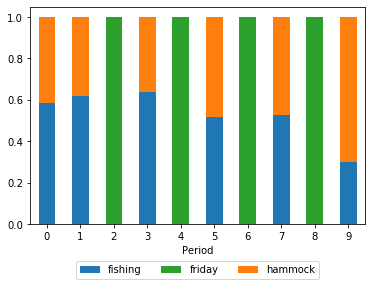

In [99]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax, color=["C0", "C2", "C1"],
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=3)

plt.show()
plt.close()

In [95]:
params

value
category                name                                     
delta                   delta                            0.950000
wage_fishing            exp_fishing                      0.100000
                        contemplation_with_friday        0.400000
nonpec_fishing          constant                        -1.000000
nonpec_friday           constant                        -1.000000
                        not_fishing_last_period         -1.000000
nonpec_hammock          constant                         2.500000
                        not_fishing_last_period         -1.000000
shocks_sdcorr           sd_fishing                       1.000000
                        sd_friday                        1.000000
                        sd_hammock                       1.000000
                        corr_friday_fishing              0.000000
                        corr_hammock_fishing            -0.200000
                        corr_hammock_friday              0.000000
lagged_choice_1_hammock constant                         1.000000
meas_error              sd_fishing                       0.000001
nonpec_friday           missing_friday             1000000.000000

## Estimating Parameters

To estimate model parameters via maximum likelihood, ``respy`` relies on [``estimagic``](https://github.com/OpenSourceEconomics/estimagic), an open-source tool to estimate structural models and more. That way, respy only has to implement the likelihood function of your model, the optimization and standard error calculation is done by estimagic. 

Unlike other optimization libraries, estimagic does not optimize over a simple vector of parameters, but instead stores parameters in a DataFrame, which makes it easier to parse them into the quantities we need, store lower and upper bounds together with parameters and express constraints on the parameters. 

For ``estimagic``, we need to pass constraints on the parameters in a list containing dictionaries. Each dictionary is a constraint. A constraint includes two components: First, we need to tell ``estimagic`` which paramters we want to constrain. This is achieved by specifying an index location which will be passed to `df.loc`. Then, define the type of the constraint. Here, we only impose the constraint that the shock parameters have to be valid variances and correlations.

Optionally, we can add a column ``"group"`` which is identical to the category column. The estimagic dashboard will then contain one parameter convergence plot per group instead of plotting all parameters in the same figure. Since respy has quite many parameters, this will make the plots much more readable.

In [63]:
from estimagic.optimization.optimize import maximize

In [64]:
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    {"loc": "delta", "type": "fixed", "value": 0.95}
]

params["group"] = params.index.get_level_values('category')

crit_func = rp.get_crit_func(params, options, df)
crit_func(params)


-17.238549136178044

In [65]:
results, params = maximize(
    crit_func, params, 
    "scipy_L-BFGS-B", 
    algo_options={"maxfun": 1}, 
    constraints=constr, 
    dashboard=False
)

If we hadn't limited the optimization to just one function evaluation, 
params would contain the estimated parameters and results would contain additional information on the optimization. 

If we hadn't set ``dashboard=False``, the call to maximize would have opened a browser window with the beautiful estimagic dashboard. Try it out if you run this notebook locally.